In [1]:
import asyncio
import warnings
import pickle as pkl
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import celltypist
from celltypist import models
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import nest_asyncio

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

warnings.filterwarnings("ignore")
nest_asyncio.apply()
sns.set_context("notebook")
sns.set_theme(style='ticks', rc={'axes.linewidth': 1})
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')


In [9]:
adata = sc.read_h5ad('../ProcessedData/seurat/annotated_prepost_csf.h5ad')

In [18]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped


# @background
def run_sccoda(
        adata: ad.AnnData, 
        sample_identifier: str, 
        cell_type_identifier: str, 
        covariate: str, 
        formula: str, 
        fdr: float, 
        save_path: str, 
        save_prefix: str
):
    """
    Run sccoda on a single cell anndata object
    
    """
    
    idx = [np.where(adata.obs[sample_identifier] == sample)[0][0] for sample in adata.obs[sample_identifier].unique()]
    summary_df = adata.obs.iloc[idx, :].sort_values(by=sample_identifier)
    summary_df.index = summary_df[sample_identifier]
    
    freq = dat.from_scanpy(
        adata,
        cell_type_identifier=cell_type_identifier,
        sample_identifier=sample_identifier,
        covariate_df=summary_df[[covariate]]
    )
    
    model = mod.CompositionalAnalysis(freq, formula=formula, reference_cell_type="automatic")
    sim_results = model.sample_hmc(verbose=False)
    
    sim_results.set_fdr(est_fdr=fdr)

    pkl.dump(sim_results, open(f'{save_path}/{save_prefix}_sccoda_{cell_type_identifier}_{covariate}.pkl', 'wb'))
    sim_results.effect_df.to_csv(f'{save_path}/{save_prefix}_scCODA_{cell_type_identifier}_{covariate}.csv')
    rich.print(f"Ran scCODA for {save_prefix}_{cell_type_identifier}_{covariate}")

    return sim_results


def effect_size_plot(
        cell_type_identifier: str,
        covariate: str,
        fdr: float,
        save_path: str,
        save_prefix: str,
        palettes,
        ax
):
    """
    
    """
    credible = sim_results.effect_df[sim_results.credible_effects()].reset_index()['Cell Type'].values
    df = sim_results.summary_prepare(hdi_prob=0.9, est_fdr=fdr)[1].reset_index()
    df['HDI 5%'] = df['HDI 5%']*-1
    df['HDI 95%'] = df['HDI 95%']*-1
    df['estimate'] = (df['HDI 5%']+df['HDI 95%'])/2.0
    df = df.sort_values('estimate', ascending=False)
    df['credible'] = df['Cell Type'].map(lambda c: 'Credible Effect' if c in credible else 'No Credible Effect')
    df['Cell Type'][df['Cell Type'] == 'Proliferating CD8+ T'] = 'Cycling CD8+ T'
    pointplot_palette = palettes
    if len(credible) == 0: pointplot_palette = [palettes[1]]
    sns.pointplot(data=df, x='estimate',y='Cell Type', hue='credible',
        dodge=False, join=False, ci=None, orient='h', markers='.',palette=pointplot_palette, ax=ax)
    
    colors = [palettes[0] if c in credible else palettes[1] for c in df['Cell Type']]
    ax.errorbar(df['estimate'], list(range(len(df['estimate']))), xerr=np.abs(df[['HDI 5%','HDI 95%']].T-df['estimate'].T),
        ecolor=colors, fmt=' ', zorder=-1)
    ax.axvline(x = 0, color = 'r', ls='--', lw='1')
    ax.set_xlabel('Effect size (90% HDI)\n Composition D0 vs D7 ', fontsize=11)
    ax.set_ylabel('')
    ax.legend().set_title('')
    ax.legend(frameon=False, bbox_to_anchor=(0.5, 1.2), loc='upper left', borderaxespad=0, fontsize='x-small')
    
def proportion_plot(
    adata: ad.AnnData, 
    sample_identifier: str,
    feature_name: str,
    level: str,
    ctype: str,
    ax,
    sig: bool,
    order: list = None,
    ylab: str = '',
    title: str = None
):
    """
    
    """
    
    idx = [np.where(adata.obs[sample_identifier] == sample)[0][0] for sample in adata.obs[sample_identifier].unique()]
    summary_df = adata.obs.iloc[idx, :].sort_values(by=sample_identifier)
    summary_df.index = summary_df[sample_identifier]

    data = dat.from_scanpy(adata, cell_type_identifier=level, sample_identifier=sample_identifier, covariate_df=summary_df[[feature_name]])
    sample_sums = np.sum(data.X, axis=1, keepdims=True)
    X = data.X/sample_sums
    value_name = "Proportion"
    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
    
    ctype_df = plot_df[plot_df['Cell type'] == ctype]

    ax = sns.boxplot(
        data=ctype_df, x=feature_name, y='Proportion', width=0.4, hue=feature_name, 
        showcaps=False, saturation=1, whis=2, order = order, 
        flierprops={"marker": ".", 'color':'black'}, boxprops={"edgecolor": 'black', "linewidth":0.9},
        whiskerprops={'color':'black', "linewidth":0.9}, medianprops={"color": "black","linewidth":1},
        palette='Accent', dodge=False, ax=ax
    )
    annotator = Annotator(ax, data=ctype_df, pairs = [order], x=feature_name, y='Proportion')
    annotator.configure(verbose=False)
    annotator.set_custom_annotations(["*" if sig else "ns"])
    annotator.annotate()

    ax.set_title(f'{ctype}' if title is None else title)
    ax.set_xlabel('')
    ax.set_ylabel(ylab)
    # ax.get_legend().remove()
    ax.locator_params(axis='y', nbins=5)
    

def proportion_plot_group(
    adata: ad.AnnData, 
    sample_identifier: str,
    feature_name: str,
    level: str,
    ctypes: str,
    ax,
    credible: list,
    order: list = None,
    bta: int = 1.15
):
    idx = [np.where(adata.obs[sample_identifier] == sample)[0][0] for sample in adata.obs[sample_identifier].unique()]
    summary_df = adata.obs.iloc[idx, :].sort_values(by=sample_identifier)
    summary_df.index = summary_df[sample_identifier]

    data = dat.from_scanpy(adata, cell_type_identifier=level, sample_identifier=sample_identifier, covariate_df=summary_df[[feature_name]])
    sample_sums = np.sum(data.X, axis=1, keepdims=True)
    X = data.X/sample_sums
    value_name = "Proportion"
    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)

    ctype_df = plot_df[plot_df['Cell type'].isin(ctypes)]

    sig_y = 1.1*ctype_df['Proportion'].max() 

    ax = sns.boxplot(
        data=ctype_df, x='Cell type', y='Proportion', width=0.6, hue=feature_name, 
        showcaps=False, saturation=1, whis=2, hue_order=order, order=ctypes,
        flierprops={"marker": ".", 'color':'black'}, boxprops={"edgecolor": 'black', "linewidth":0.9},
        whiskerprops={'color':'black', "linewidth":0.9}, medianprops={"color": "black","linewidth":1},
        palette='Accent', ax=ax
    )
    [ax.axvline(x+.5,color='grey', lw=0.05, ls=':') for x in ax.get_xticks()[:-1]]

    for i in range(len(ctypes)):
        kwargs=dict(ha="center", va="bottom", size=14)
        if ctypes[i] in credible:
            plt.text(y=sig_y, x=i, s="*", color=sns.color_palette('Set1')[0], **kwargs)
            plt.text(y=sig_y, x=i, s="__", color=sns.color_palette('Set1')[0], **kwargs)


    ax.set_ylim(ax.get_ylim()[0],1.15*sig_y)
    ax.set_xlabel('')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='y', colors='black')
    ax.tick_params(axis='x', colors='black')
    plt.legend(frameon=False, bbox_to_anchor=(bta, 1))
    plt.xticks(rotation=90)
    # adjust_box_widths(fig, 0.8)

from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [8]:
adata_d07 = adata[adata.obs['Day'].isin(['D0','D7'])]

In [11]:
adata_d07_noncar = adata_d07[~adata_d07.obs['cell_type'].isin(['CD8+ CAR T','CD4+ CAR T','Mixed CAR+/CAR- Tfh'])].copy()

In [12]:
covariate  = 'Day'
run_sccoda(adata_d07_noncar, 'sample_id', 'cell_type', covariate, f"C({covariate}, Treatment('D7'))", 0.1, 'results/sccoda', 'day07_noncar')         

Automatic reference selection! Reference cell type set to B
Zero counts encountered in data! Added a pseudocount of 0.5.


I0000 00:00:1745669672.180052    1525 service.cc:148] XLA service 0xfffa980070f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745669672.180181    1525 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1745669672.534264    1525 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


MCMC sampling finished. (101.264 sec)
Acceptance rate: 57.5%


Ran scCODA for day07_noncar_cell_type_Day

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [14]:
with open(f'results/sccoda/day07_noncar_sccoda_cell_type_Day.pkl', 'rb') as file:
    sim_results = pkl.load(file)

In [15]:
credible = sim_results.effect_df[sim_results.credible_effects()].reset_index()['Cell Type'].values
df = sim_results.summary_prepare(hdi_prob=0.9, est_fdr=0.1)[1].reset_index()

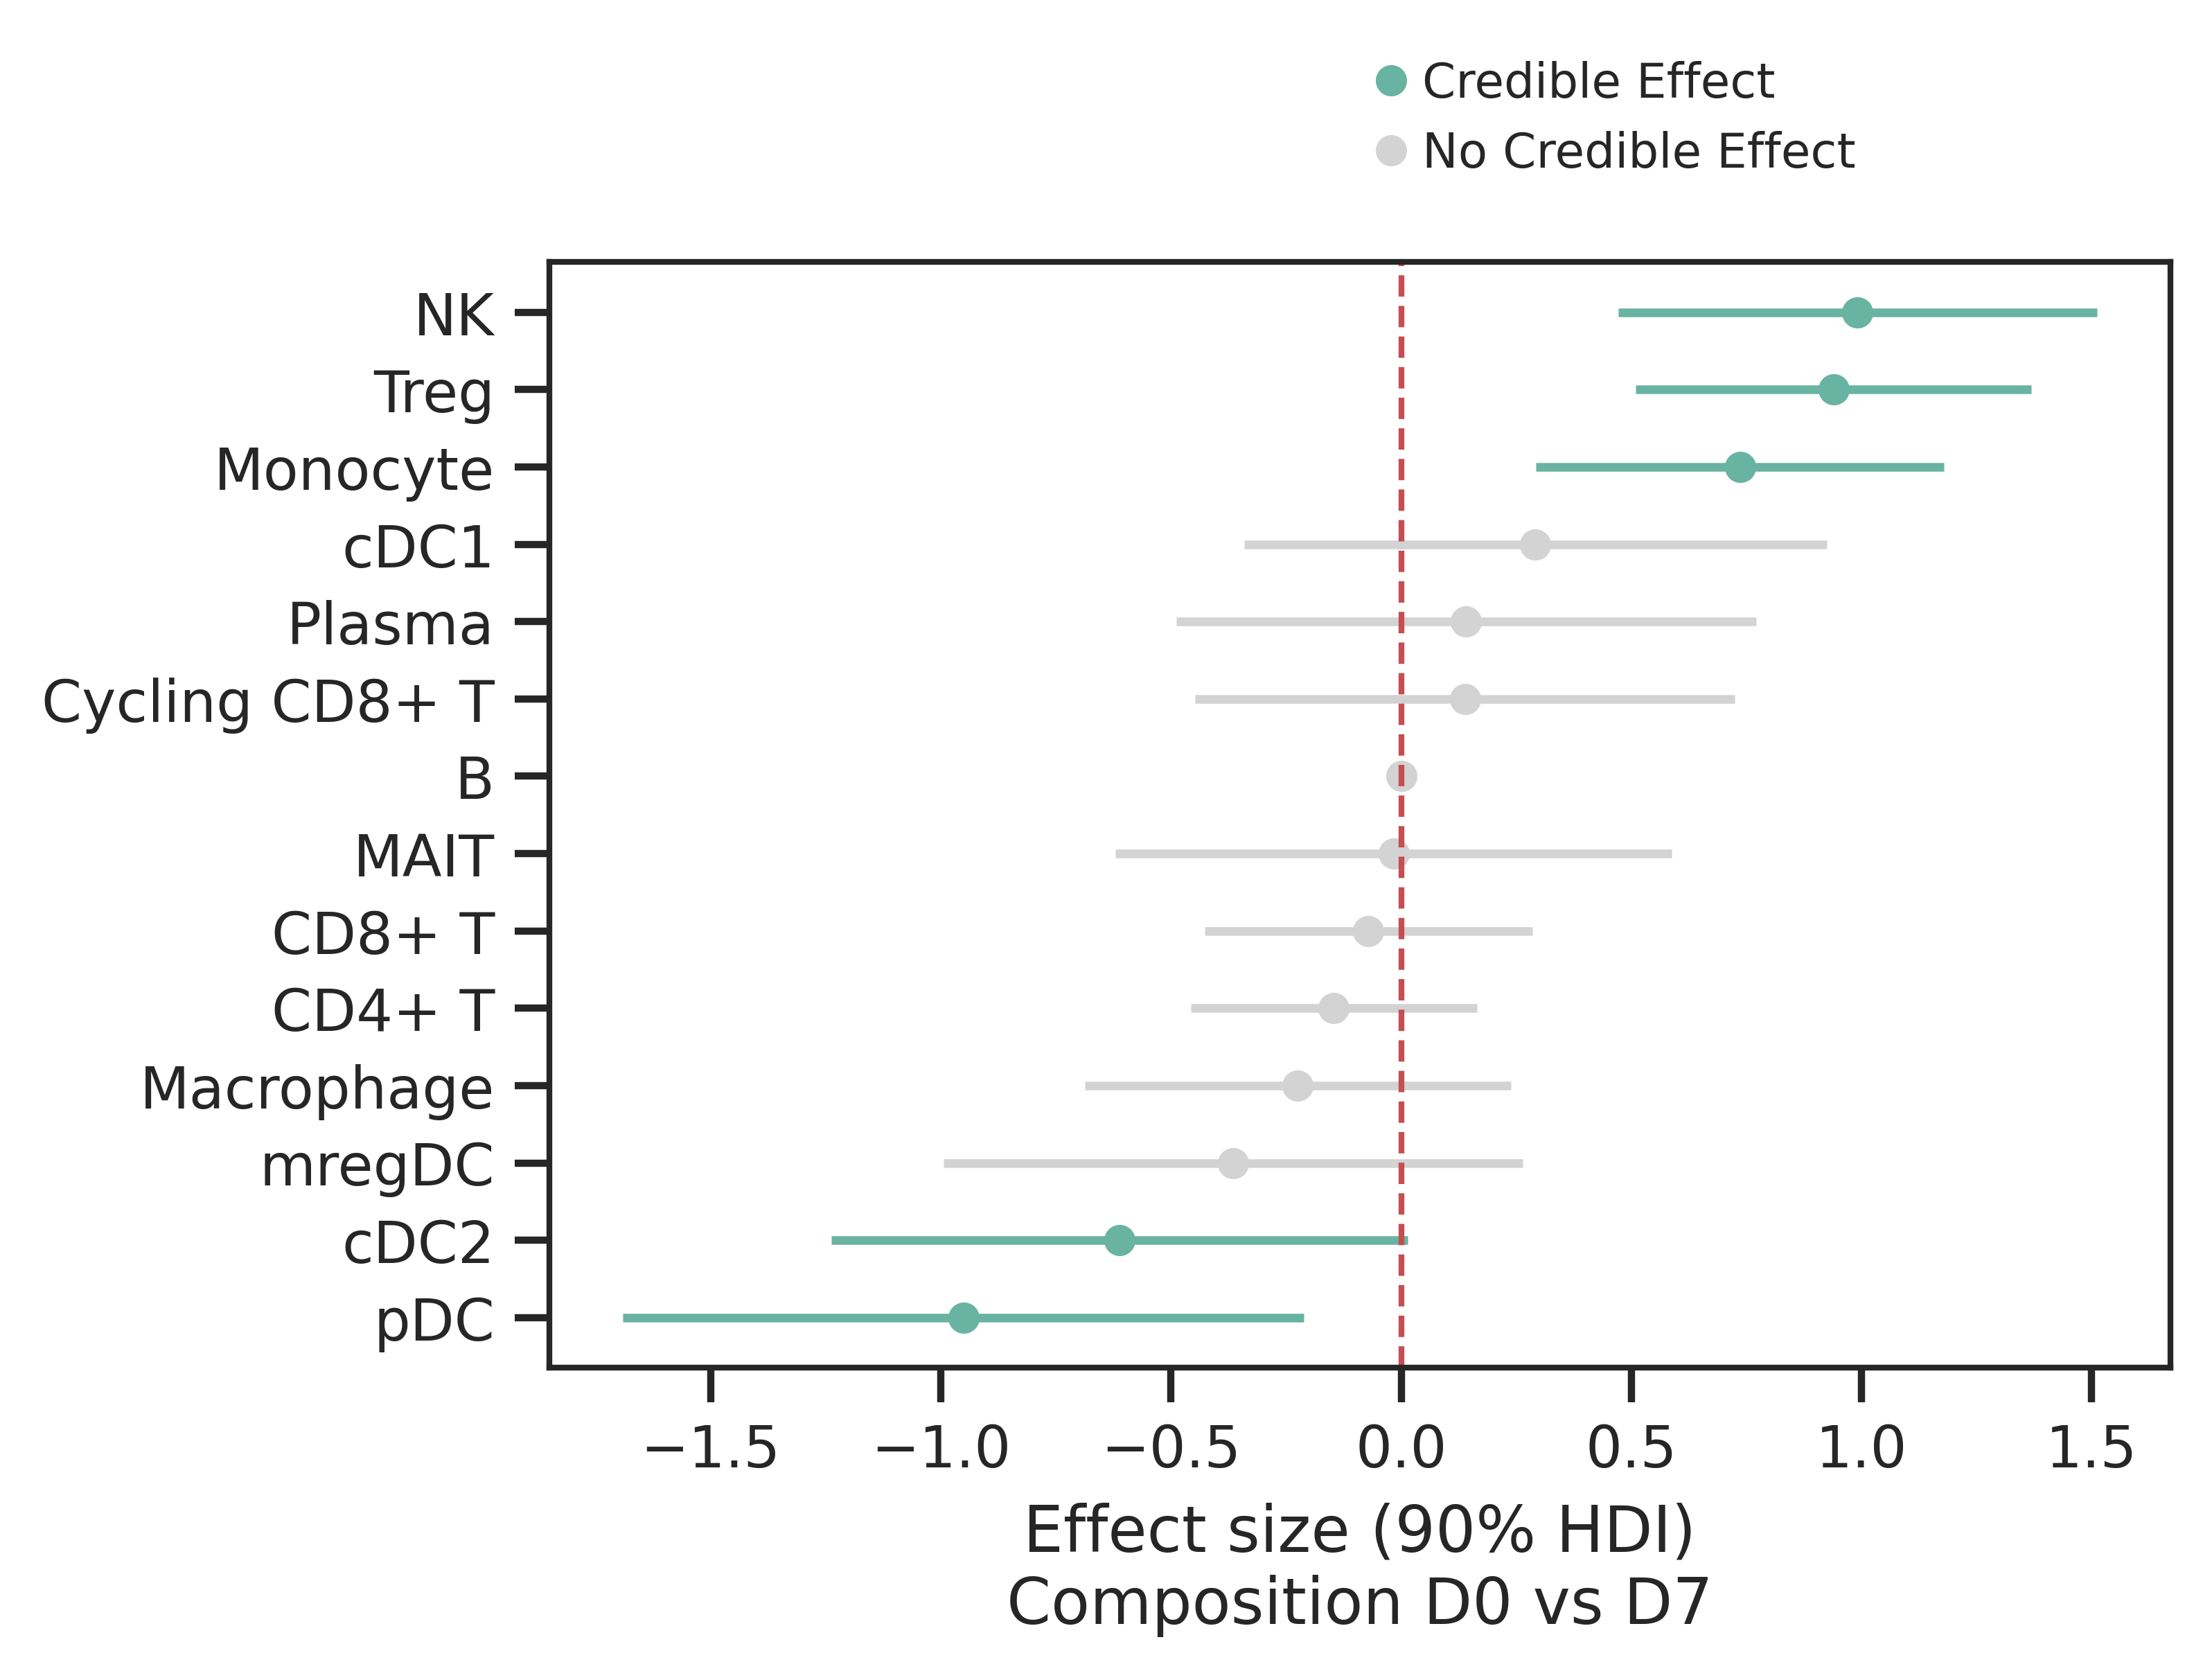

In [19]:
fig = plt.figure(figsize=(5, 3.5), dpi=300)
ax1 = plt.subplot(1,1,1)
effect_size_plot('cell_type', covariate, 0.1, 'results/sccoda', 'day07_noncar', ax=ax1, palettes=["#69b3a2","lightgrey"])# sns.color_palette()[-4:-2])

In [20]:
fig.subplots_adjust(top=0.8, bottom=0.2, left=0.35)  # Adjust top and bottom margins to prevent cutting off labels

In [21]:
fig.savefig("Figures/1G.pdf", format="pdf", dpi=300)

In [25]:
# adata_d07 = adata

In [26]:
adata_d721_noncar = adata_d721[~adata_d721.obs['cell_type'].isin(['CD8+ CAR T','CD4+ CAR T'])].copy()

In [27]:
covariate  = 'Day'
run_sccoda(adata_d721_noncar, 'sample_id', 'cell_type', covariate, f"C({covariate}, Treatment('D21'))", 0.1, 'results/sccoda', 'day721_noncar')         

Automatic reference selection! Reference cell type set to cDC2
Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (97.922 sec)
Acceptance rate: 62.9%


Ran scCODA for day721_noncar_cell_type_Day

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [29]:
adata_d721_noncar.obs['Day'].unique()

array(['D7', 'D21'], dtype=object)

In [30]:
with open(f'results/sccoda/day721_noncar_sccoda_cell_type_Day.pkl', 'rb') as file:
    sim_results = pkl.load(file)

In [43]:
credible = sim_results.effect_df[sim_results.credible_effects()].reset_index()['Cell Type'].values
df = sim_results.summary_prepare(hdi_prob=0.9, est_fdr=0.1)[1].reset_index()

In [44]:
sns.color_palette()[-4:-2]

[(0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]

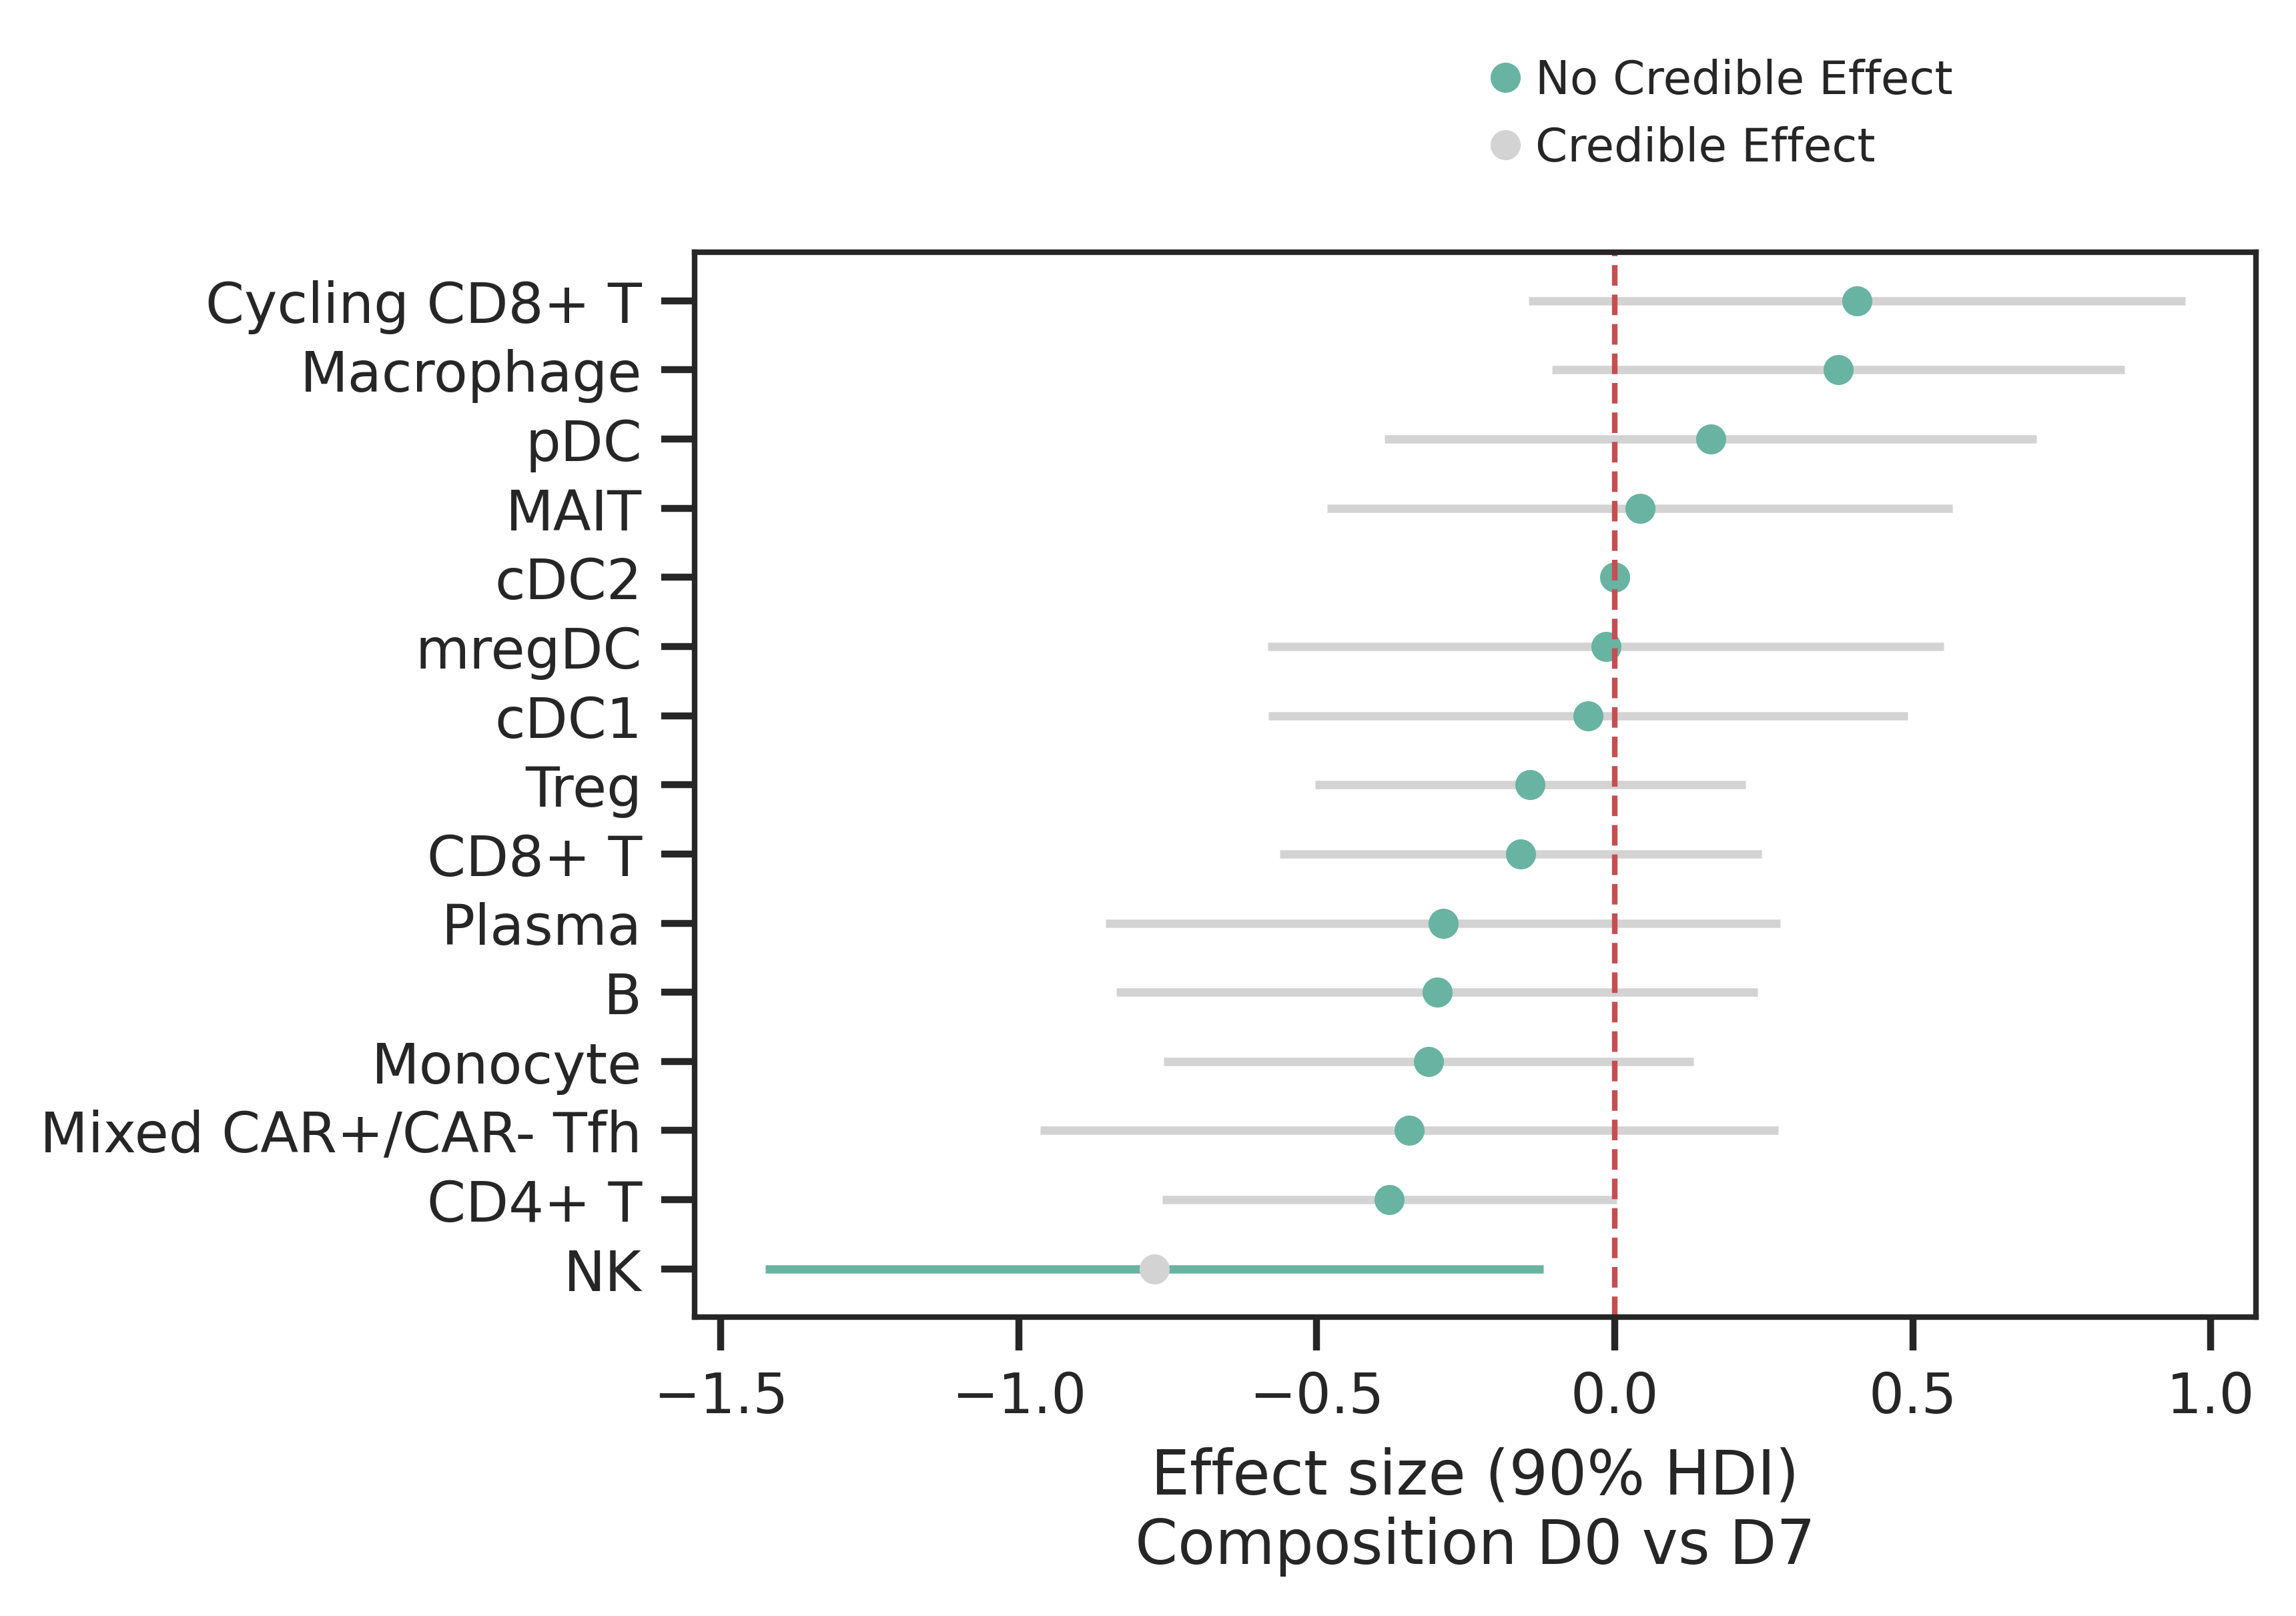

In [42]:
fig = plt.figure(figsize=(5, 3.5), dpi=300)
ax1 = plt.subplot(1,1,1)
effect_size_plot('cell_type', covariate, 0.1, 'results/sccoda', 'day721_noncar', ax=ax1, palettes=["#69b3a2","lightgrey"])# sns.color_palette()[-4:-2])

In [ ]:
fig.subplots_adjust(top=0.8, bottom=0.2, left=0.35)  # Adjust top and bottom margins to prevent cutting off labels

In [45]:
fig.savefig("Final/Figures/D7_vs_D21_composition.pdf", format="pdf", dpi=300)

In [48]:
sim_results = pkl.load(open(f'results/sccoda/day721_noncar_sccoda_cell_type_Day.pkl', 'rb'))
sim_results.set_fdr(est_fdr=0.1)
credible = [c for c in sim_results.effect_df[sim_results.credible_effects()].reset_index()['Cell Type'].values]
credible

['NK']

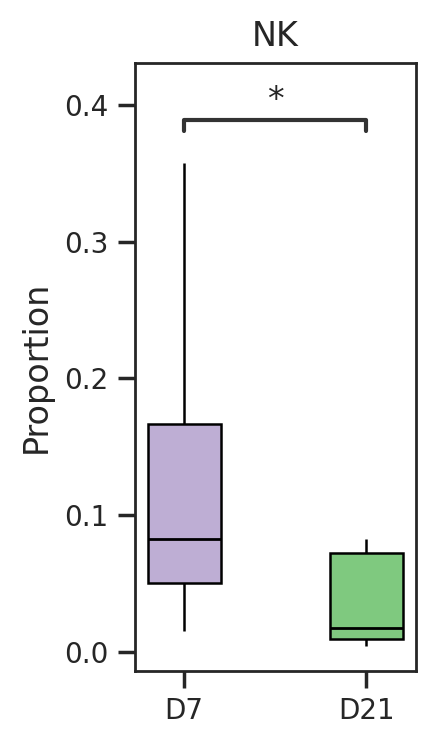

In [52]:
ctype = 'NK'
fig, ax = plt.subplots(figsize=(1.8, 4), dpi=100)
proportion_plot(
    adata_d721_noncar, 'sample_id', 'Day', 'cell_type', ctype, ax=ax, ylab='Proportion', order=['D7', 'D21'], sig=(ctype in credible)
)

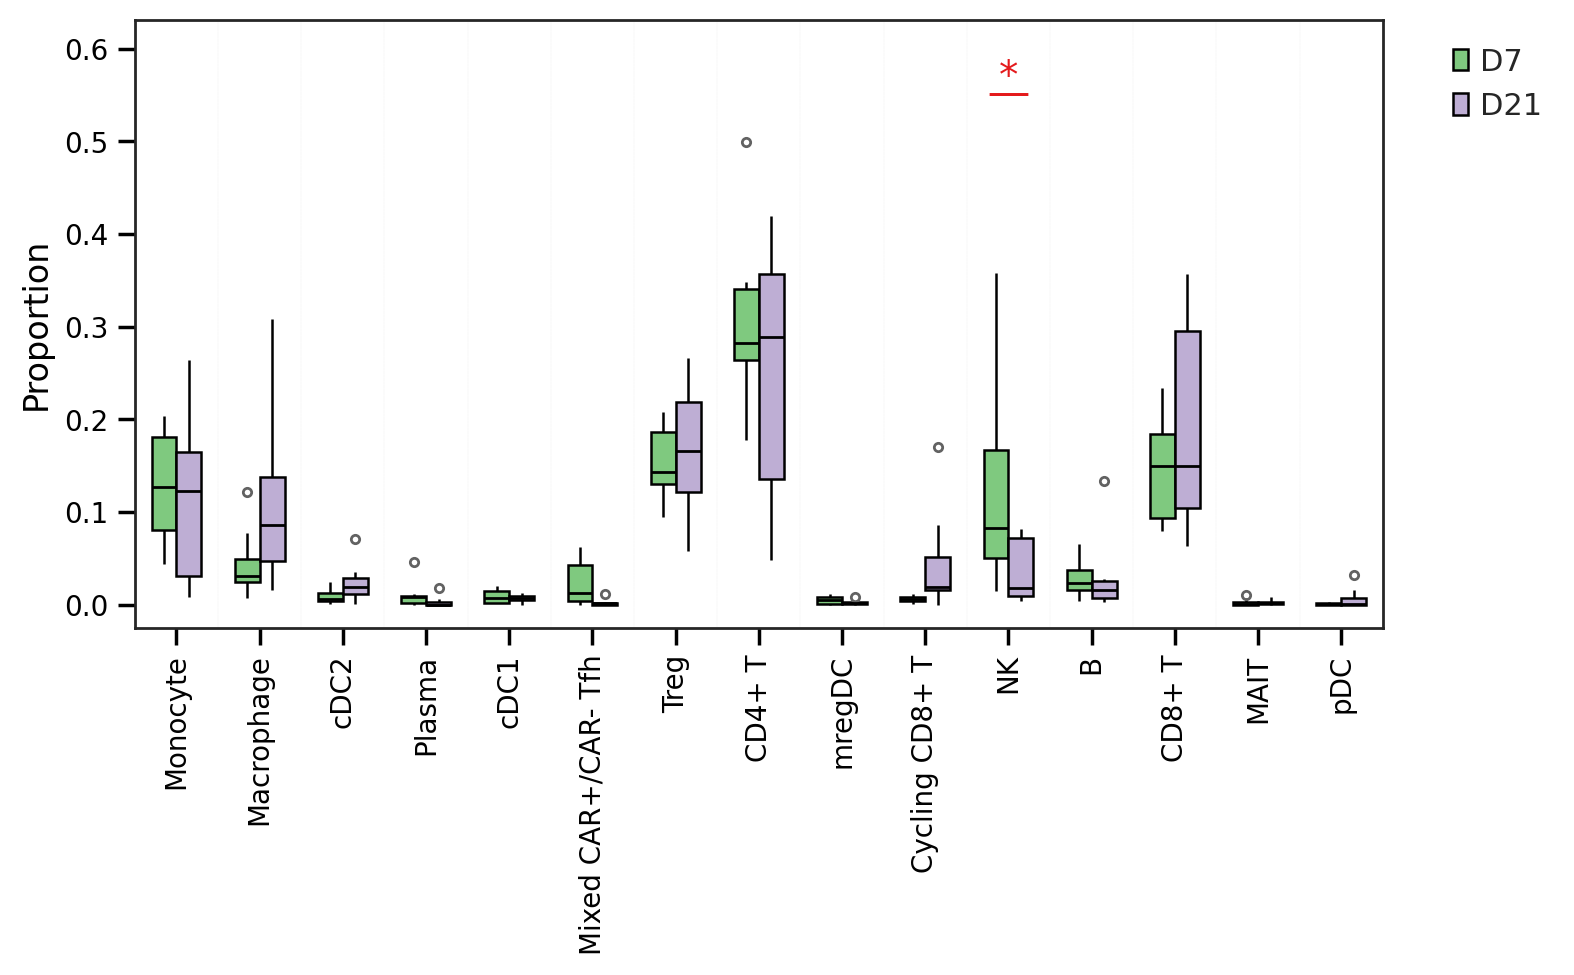

In [54]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

proportion_plot_group(adata_d721_noncar, 'sample_id', 'Day', 'cell_type', 
    ctypes=list(adata_d721_noncar.obs['cell_type'].unique()), ax=ax, credible=credible, order=['D7','D21'])

In [55]:
fig.savefig("Final/Figures/D7_vs_D21_supp.pdf", format="pdf", dpi=300)